In [1]:
from torch import nn
from lib.models import Frodo
import torch
CONFIG = {
    'WINDOW_SIZE':5000,
    'BATCH_SIZE':512,
    'LEARNING_RATE':3e-4,
    'DEVICE':'cuda'
}
class Gandalf(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Frodo(n_features=5000)
        self.lstm = nn.LSTM(16,32,bidirectional=True)
        self.fc1 = nn.Linear(64,3)
    def forward(self,x_2d,classification=True):
        x_2d = x_2d.view(-1,9,1,5000)
        x = []
        for t in range(x_2d.size(1)):
            xi = self.encoder(x_2d[:,t,:,:],classification=False)
            x.append(xi.unsqueeze(0))
        x = torch.cat(x,dim=0)
        out,_ = self.lstm(x)
        if(classification):
            x = self.fc1(out[-1])
        else:
            x = out[-1]
        return x

In [2]:
from lib.datasets import SequencedDataset,EpochedDataset
from torch.utils.data import ConcatDataset,DataLoader
from lib.ekyn import get_ekyn_ids
from sklearn.model_selection import train_test_split
train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)
trainloader = DataLoader(ConcatDataset([SequencedDataset(idx=idx,condition=condition,sequence_length=9) for idx in train_idx for condition in ['Vehicle','PF']]),batch_size=64,shuffle=True)

In [3]:
model = Gandalf()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=CONFIG['LEARNING_RATE'])
model.to(CONFIG['DEVICE']);

In [4]:
lossi = []
from tqdm import tqdm

In [5]:
for i in range(1):
    for Xi,yi in tqdm(trainloader):
        Xi,yi = Xi.to(CONFIG['DEVICE']),yi.to(CONFIG['DEVICE'])
        logits = model(Xi)
        loss = criterion(logits,yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
loss

  0%|          | 0/3240 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 3240/3240 [10:31<00:00,  5.13it/s]


tensor(0.3018, device='cuda:0', grad_fn=<DivBackward1>)

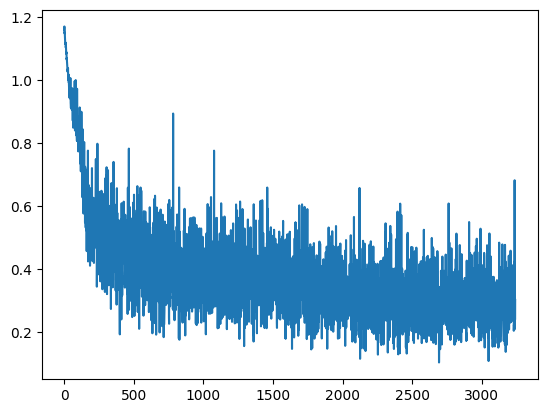

In [6]:
import matplotlib.pyplot as plt
plt.plot(lossi)

In [7]:
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=trainloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

  2%|▏         | 69/3240 [00:04<03:48, 13.86it/s]


KeyboardInterrupt: 

In [9]:
devloader = DataLoader(ConcatDataset([SequencedDataset(idx=idx,condition=condition,sequence_length=9) for idx in test_idx for condition in ['Vehicle','PF']]),batch_size=128,shuffle=True)

100%|██████████| 540/540 [01:07<00:00,  8.03it/s]


              precision    recall  f1-score   support

         0.0       0.25      0.42      0.31      3504
         1.0       0.90      0.96      0.93     31617
         2.0       0.90      0.79      0.84     33999

    accuracy                           0.85     69120
   macro avg       0.68      0.72      0.69     69120
weighted avg       0.87      0.85      0.85     69120

0.33888895715828293


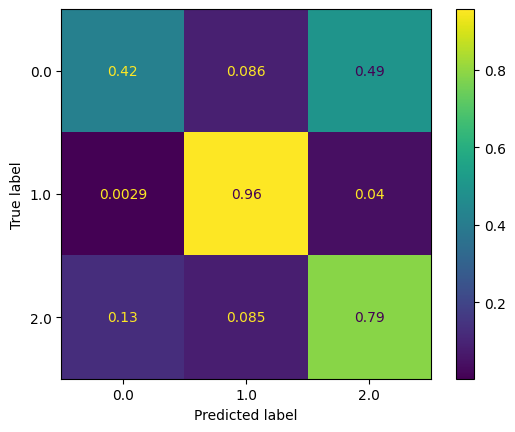

: 

In [10]:
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)